In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
import data
from tensorflow import keras

plt.rcParams.update({'font.size': 16})

## Load data

In [2]:
dfile = "test/Teuk_amps_a0.1-0.99_lmax_10_nmax_30.hdf5"
dat = data.PrepareData(dfile)

File path: test/
File name: Teuk_amps_a0.1-0.99_lmax_10_nmax_30_prograde
Loading parameters from: test/Teuk_amps_a0.1-0.99_lmax_10_nmax_30_prograde_pars.dat
Loading modes from: test/Teuk_amps_a0.1-0.99_lmax_10_nmax_30_prograde_modes.dat
Input dimensions: 3
Output dimensions: 1256


In [3]:
print(dat.__dict__.keys())

dict_keys(['data_file', 'fname', 'path', 'prograde', 'save_tt', 'rb_tolerance', 'test_fraction', 'pars_all', 'modes_all', 'pars_train', 'pars_test', 'modes_train', 'modes_test', 'red_basis', 'rb_alpha', 'input_train', 'input_dim', 'output_train', 'output_dim'])


## Reduced-order basis

In [4]:
print("Basis pts:", dat.rb_alpha.shape[0])

output_proj = np.matmul(dat.rb_alpha.T, dat.red_basis)
output_maxrse = np.amax(np.linalg.norm(output_proj - dat.modes_train, axis=1)\
                        /np.linalg.norm(dat.modes_train, axis=1))**2
output_minover = np.amin(np.real(np.sum(np.conjugate(output_proj) * dat.modes_train, axis=1)\
                        /np.linalg.norm(output_proj, axis=1) / np.linalg.norm(dat.modes_train, axis=1)))

print('Max relative squared error:', output_maxrse, '\nMin overlap:', output_minover)

Basis pts: 628
Max relative squared error: 0.0002642888292808161 
Min overlap: 0.9998678468531325


## Trained Network

In [6]:
model = keras.models.load_model("kerr_train_saved_model/model_5")

acc_loss = np.loadtxt("log/kerr_train.log")

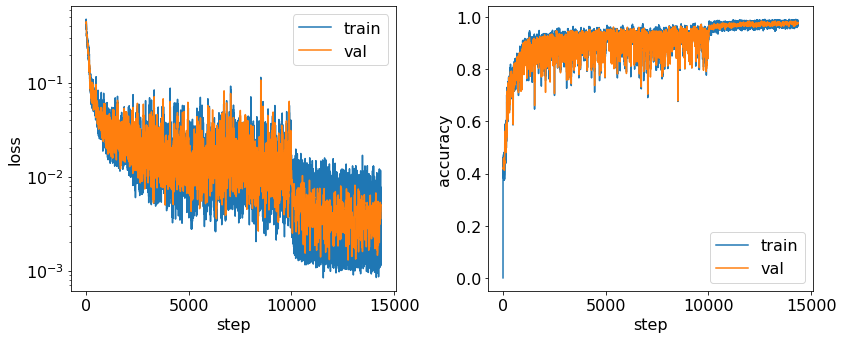

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].semilogy(acc_loss[:, 0], label="train")
ax[0].semilogy(acc_loss[:, 2], label="val")
ax[0].set_xlabel("step")
ax[0].set_ylabel("loss")
ax[0].legend(loc=0)

ax[1].plot(acc_loss[:, 1], label="train")
ax[1].plot(acc_loss[:, 3], label="val")
ax[1].set_xlabel("step")
ax[1].set_ylabel("accuracy")
ax[1].legend(loc=0)

plt.tight_layout()

plt.show()

In [11]:
train_out = model.predict_on_batch(dat.input_train)
train_out = np.reshape(train_out/1e3, [dat.output_train.shape[0], 2, int(dat.output_dim/2)])
train_out = train_out[:, 0] + 1j*train_out[:, 1]

#undo order reduction
train_proj = np.matmul(train_out, dat.red_basis)

train_rse = (np.linalg.norm(train_proj - dat.modes_train, axis=1)\
             /np.linalg.norm(dat.modes_train, axis=1))**2

train_over = np.real(np.sum(np.conjugate(train_proj) * dat.modes_train, axis=1)\
            /np.linalg.norm(train_proj, axis=1) / np.linalg.norm(dat.modes_train, axis=1))

train_diff = np.abs(np.linalg.norm(train_proj, axis=1)**2 - np.linalg.norm(dat.modes_train, axis=1)**2) \
           /np.linalg.norm(dat.modes_train, axis=1)**2

In [12]:
train_rsemed = np.median(train_rse)
train_rseiqr = np.quantile(train_rse, 0.75) - np.quantile(train_rse, 0.25)
train_rsemax = np.amax(train_rse)

train_overmed = np.median(1 - train_over)
train_overiqr = np.quantile(1 - train_over, 0.75) - np.quantile(1 - train_over, 0.25)
train_overmax = np.amax(1 - train_over)

train_diffmed = np.median(train_diff)
train_diffiqr = np.quantile(train_diff, 0.75) - np.quantile(train_diff, 0.25)
train_diffmax = np.amax(train_diff)

print(f'Squared L2 error (median, IQR, max): ({train_rsemed}, {train_rseiqr}, {train_rsemax})')
print(f'Mode distribution error (median, IQR, max): ({train_overmed}, {train_overiqr}, {train_overmax})')
print(f'Total power error (median, IQR, max): ({train_diffmed}, {train_diffiqr}, {train_diffmax})')

Squared L2 error (median, IQR, max): (0.0006942547783548047, 0.003353939838296915, 0.5478521470636271)
Mode distribution error (median, IQR, max): (0.00030516200606922617, 0.0014497323669790951, 0.3274853748119847)
Total power error (median, IQR, max): (0.009517358522242982, 0.017708118761316345, 0.5955049601160929)


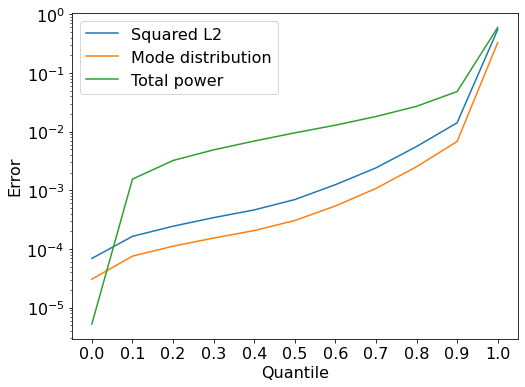

In [13]:
quant = np.linspace(0, 1, 11)

plt.figure(figsize=(8,6))
plt.plot(quant, np.quantile(train_rse, quant), label='Squared L2')
plt.plot(quant, np.quantile(1 - train_over, quant), label='Mode distribution')
plt.plot(quant, np.quantile(train_diff, quant), label='Total power')
plt.legend()
plt.xticks(quant)
plt.yscale('log')
plt.xlabel('Quantile')
plt.ylabel('Error')
plt.show()

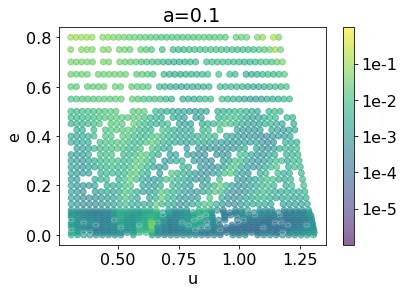

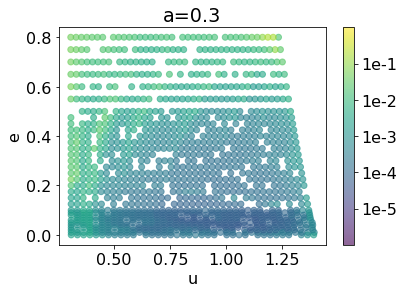

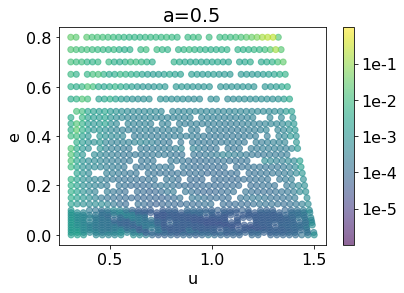

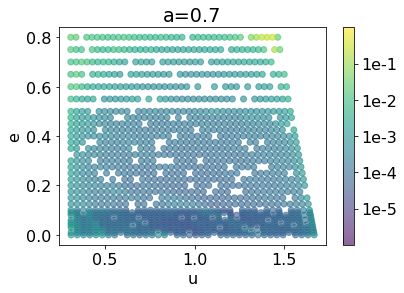

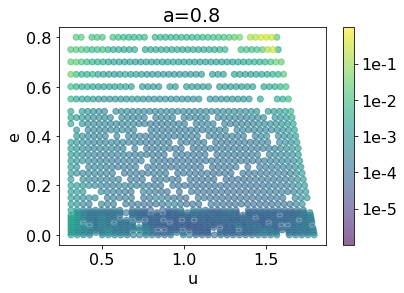

In [14]:
#dist errors

a_vals = np.unique(dat.input_train[:, 0])

for a in a_vals:
    
    pts = np.where(dat.input_train[:, 0] == a)[0]

    fig, ax = plt.subplots()
    plt.title("a={}".format(a))
    cax = ax.scatter(dat.input_train[pts, 1], dat.input_train[pts, 2], \
                 c=1 + np.log10(1 - train_over[pts])/6, alpha=0.6, \
                 cmap='viridis', vmin=0, vmax=1)
    cbar = fig.colorbar(cax, ticks=1 + np.log10(1 - np.array([0.99999, 0.9999, 0.999, 0.99, 0.9]))/6)
    cbar.ax.set_yticklabels(['1e-5','1e-4','1e-3','1e-2','1e-1'])
    plt.xlabel('u')
    plt.ylabel('e')
    plt.show()


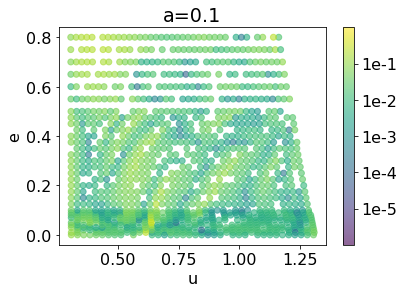

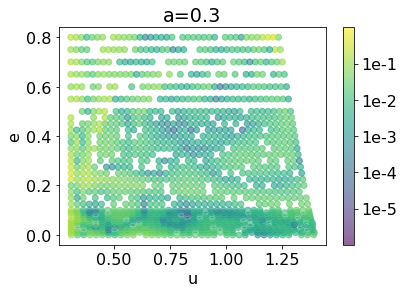

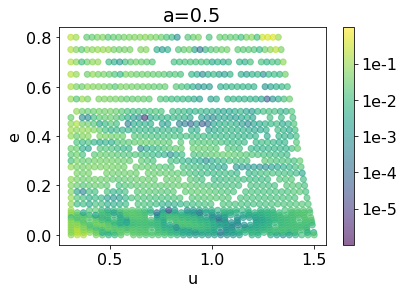

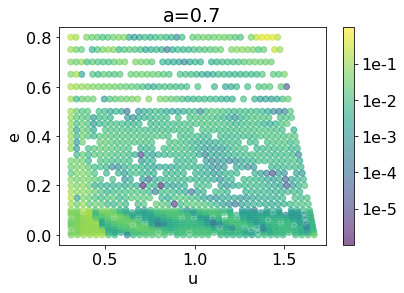

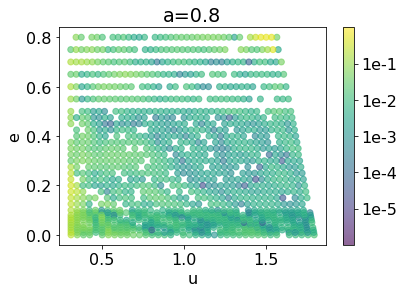

In [12]:
#pow errors

a_vals = np.unique(dat.input_train[:, 0])

for a in a_vals:
    
    pts = np.where(dat.input_train[:, 0] == a)[0]

    fig, ax = plt.subplots()
    plt.title("a={}".format(a))
    cax = ax.scatter(dat.input_train[pts, 1], dat.input_train[pts, 2], \
                 c=1 + np.log10(train_diff[pts])/6, alpha=0.6, \
                 cmap='viridis', vmin=0, vmax=1)
    cbar = fig.colorbar(cax, ticks=1 + np.log10(1 - np.array([0.99999, 0.9999, 0.999, 0.99, 0.9]))/6)
    cbar.ax.set_yticklabels(['1e-5','1e-4','1e-3','1e-2','1e-1'])
    plt.xlabel('u')
    plt.ylabel('e')
    plt.show()

In [15]:
#p to u
u = dat.u_transform(dat.pars_test[:, 0], dat.pars_test[:, 1], dat.pars_test[:, 2])
input_test = np.c_[dat.pars_test[:, 0], u, dat.pars_test[:, 2]]

test_out = model.predict_on_batch(input_test)
test_out = np.reshape(test_out/1e3, [input_test.shape[0], 2, int(dat.output_dim/2)])
test_out = test_out[:, 0] + 1j*test_out[:, 1]

#undo order reduction
test_proj = np.matmul(test_out, dat.red_basis)

test_rse = (np.linalg.norm(test_proj - dat.modes_test, axis=1)\
             /np.linalg.norm(dat.modes_test, axis=1))**2

test_over = np.real(np.sum(np.conjugate(test_proj) * dat.modes_test, axis=1)\
            /np.linalg.norm(test_proj, axis=1) / np.linalg.norm(dat.modes_test, axis=1))

test_diff = np.abs(np.linalg.norm(test_proj, axis=1)**2 - np.linalg.norm(dat.modes_test, axis=1)**2) \
           /np.linalg.norm(dat.modes_test, axis=1)**2

In [16]:
test_rsemed = np.median(test_rse)
test_rseiqr = np.quantile(test_rse, 0.75) - np.quantile(test_rse, 0.25)
test_rsemax = np.amax(test_rse)

test_overmed = np.median(1 - test_over)
test_overiqr = np.quantile(1 - test_over, 0.75) - np.quantile(1 - test_over, 0.25)
test_overmax = np.amax(1 - test_over)

test_diffmed = np.median(test_diff)
test_diffiqr = np.quantile(test_diff, 0.75) - np.quantile(test_diff, 0.25)
test_diffmax = np.amax(test_diff)

print(f'Squared L2 error (median, IQR, max): ({test_rsemed}, {test_rseiqr}, {test_rsemax})')
print(f'Mode distribution error (median, IQR, max): ({test_overmed}, {test_overiqr}, {test_overmax})')
print(f'Total power error (median, IQR, max): ({test_diffmed}, {test_diffiqr}, {test_diffmax})')

Squared L2 error (median, IQR, max): (0.0008504727347805013, 0.0044846468693353, 0.4507487745367476)
Mode distribution error (median, IQR, max): (0.00037476702163941056, 0.002070400843158654, 0.2582005101895174)
Total power error (median, IQR, max): (0.009834290451580251, 0.01766111191778783, 0.4465802638775187)


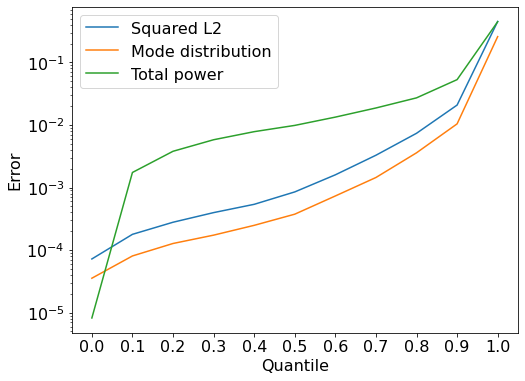

In [17]:
quant = np.linspace(0, 1, 11)

plt.figure(figsize=(8,6))
plt.plot(quant, np.quantile(test_rse, quant), label='Squared L2')
plt.plot(quant, np.quantile(1 - test_over, quant), label='Mode distribution')
plt.plot(quant, np.quantile(test_diff, quant), label='Total power')
plt.legend()
plt.xticks(quant)
plt.yscale('log')
plt.xlabel('Quantile')
plt.ylabel('Error')
plt.show()

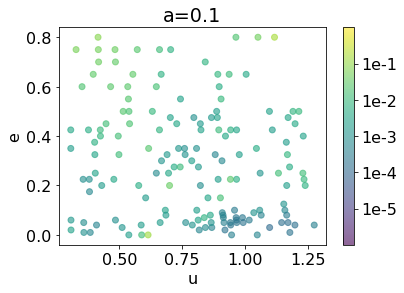

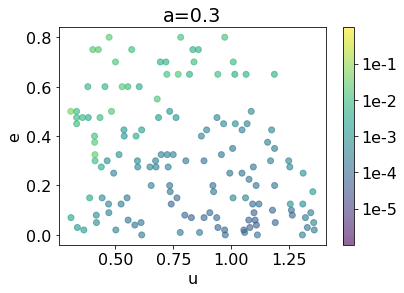

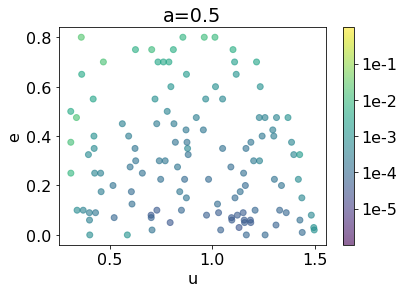

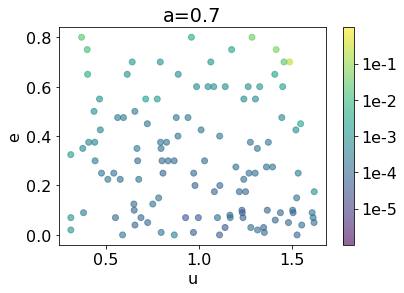

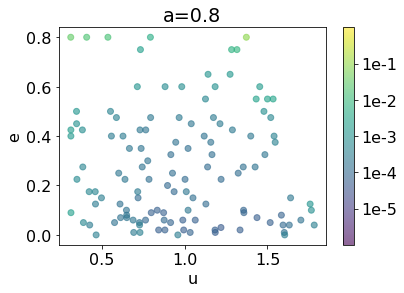

In [19]:
a_vals = np.unique(input_test[:, 0])

for a in a_vals:
    
    pts = np.where(input_test[:, 0] == a)[0]

    fig, ax = plt.subplots()
    plt.title("a={}".format(a))
    cax = ax.scatter(input_test[pts, 1], input_test[pts, 2], \
                 c=1 + np.log10(1 - test_over[pts])/6, alpha=0.6, \
                 cmap='viridis', vmin=0, vmax=1)
    cbar = fig.colorbar(cax, ticks=1 + np.log10(1 - np.array([0.99999, 0.9999, 0.999, 0.99, 0.9]))/6)
    cbar.ax.set_yticklabels(['1e-5','1e-4','1e-3','1e-2','1e-1'])
    plt.xlabel('u')
    plt.ylabel('e')
    plt.show()

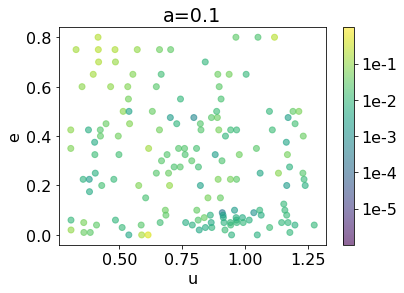

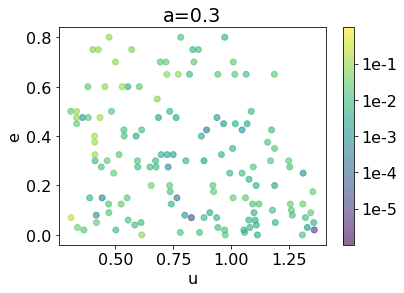

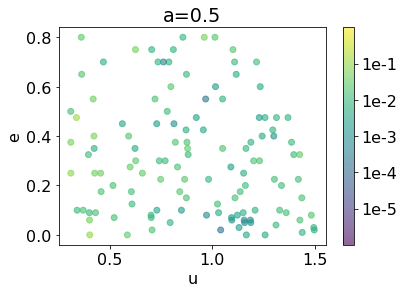

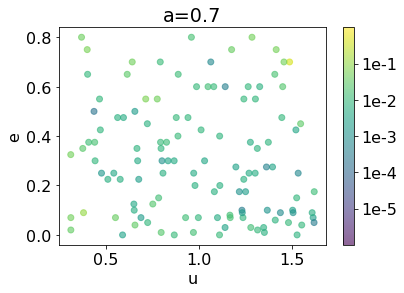

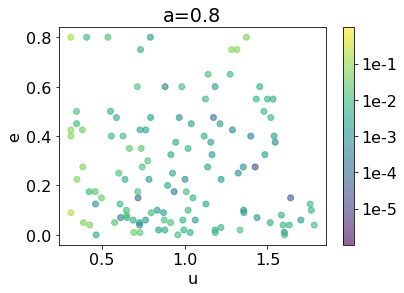

In [20]:
a_vals = np.unique(input_test[:, 0])

for a in a_vals:
    
    pts = np.where(input_test[:, 0] == a)[0]

    fig, ax = plt.subplots()
    plt.title("a={}".format(a))
    cax = ax.scatter(input_test[pts, 1], input_test[pts, 2], \
                 c=1 + np.log10(test_diff[pts])/6, alpha=0.6, \
                 cmap='viridis', vmin=0, vmax=1)
    cbar = fig.colorbar(cax, ticks=1 + np.log10(1 - np.array([0.99999, 0.9999, 0.999, 0.99, 0.9]))/6)
    cbar.ax.set_yticklabels(['1e-5','1e-4','1e-3','1e-2','1e-1'])
    plt.xlabel('u')
    plt.ylabel('e')
    plt.show()

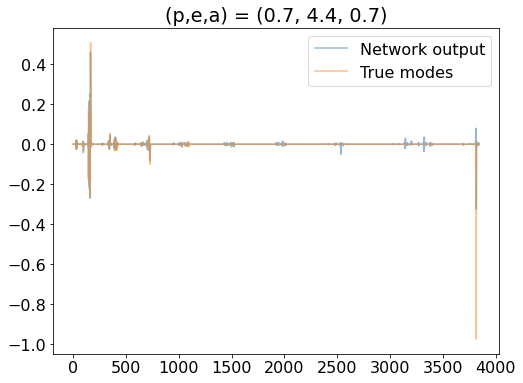

In [26]:
plt.figure(figsize=(8,6))
plt.plot(np.real(test_proj[np.argmax(1 - test_over)]), alpha=0.5, label='Network output')
plt.plot(np.real(dat.modes_test[np.argmax(1 - test_over)]), alpha=0.5, label='True modes')
plt.legend()
plt.title(f'(p,e,a) = ({dat.pars_test[np.argmax(1-test_over)][0]:.1f}, {dat.pars_test[np.argmax(1-test_over)][1]:.1f}, {dat.pars_test[np.argmax(1-test_over)][2]:.1f})')
plt.show()